# Module 2: Water flow in soil

*by Daniel Leitner, Andrea Schnepf, Valentin Couvreur, Axelle Koch*

In [5]:
# Importe libraries and define some auxiliary functions:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import * 
import os
import ast

## M2.1: Comparison of numerical solutions to reference solution

There are many softwares solving Richards equation. Benchmark M2.1 was evaluated for *Macro*, *Hydrus1D*, *Swap*, *Marthe*, and *Wave* in Vanderborght et al. (2005). With this Jupyter Notebook, we enable automated comparison of the results of additional numerical codes. The easiest way to contribute is to implement this benchmark problem and provide the results to be stored in the specified folder on the github repository.  

In addition, we provide links to Jupyter Notebooks that describe the numerical implementation of a benchmark problem in a specific code should they be available:

* [Dumux](Soil water flow - Dumux.ipynb)

### Benchmark M2.1

For an automatic comparison of the numerical results, save the results in a text file, each result consisting of two rows containing comma separated depth values [cm] in the first, and water content [1] in the second. This is done for each time point and infiltration scenario (i.e. 3 (time points) * 3 (scenarios) results = 18 rows). Copy the file to the folder /M2.1 Numerical results/.

In [6]:
# Mualem - van Genuchten model, equations from van Genuchten, MT (1980)

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*sqrt(se)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11)
def water_diffusivity(TH, theta_i, theta_sur, sp):
    theta = TH * (theta_i - theta_sur) + theta_sur
    Se = (theta - sp.theta_R) / (sp.theta_S - sp.theta_R)
    m = sp.m
    D = (1 - m) * sp.Ksat / (sp.alpha * m * (sp.theta_S - sp.theta_R)) * pow(Se, 0.5 - 1. / m) * (pow(1 - pow(Se, 1. / m), -m) + pow(1 - pow(Se, 1 / m), m) - 2)
    return D
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

In [7]:
#The analytical solution
tv=[ [0.1, 0.2, 0.3], [0.2, 0.5, 1.0], [0.1, 0.2, 0.5] ] # time values (days)
t_a2 = [0.1, 0.2, 0.1] 
x_aa = [43, 41, 27.5]     
theta3 = []
z3 = []

for i, soil in enumerate([sand, loam, clay]): # make three subplots
        
    if soil==sand:
        theta_sur = 0.2824 # calculated form the influx 100 cm/day
    else:
        theta_sur = soil.theta_S  # full saturation          
    theta_i = water_content(-400,soil);
        
    K_sur = hydraulic_conductivity( pressure_head(theta_sur,soil), soil);
    K_i = hydraulic_conductivity(-400, soil)
    psi = lambda theta: pressure_head(theta,soil)
    K = lambda psi: hydraulic_conductivity(psi,soil)
    Dw = lambda psi: K(psi)/(specific_moisture_storage(psi,soil))            
    F = lambda theta:  Dw(psi(theta)) / ( (K_sur - K_i)*(theta - theta_i) - (K(psi(theta)) - K_i)*(theta_sur - theta_i) ) 
    
    theta_a = (theta_sur+theta_i)/2
    theta_ = np.linspace (theta_i+1e-3,theta_sur-1e-3,2000)

    delta_eta = np.zeros(len(theta_),)
    for j in range(0,len(theta_)):
        ans, err = integrate.quad(F,theta_[j],theta_a)
        delta_eta[j] = ans
    
    delta_eta = delta_eta * (theta_sur - theta_i)
    x_a = x_aa[i]
    t_a = t_a2[i]        
    eta_a = x_a - (K_sur-K_i)/(theta_sur - theta_i)*t_a
    eta = delta_eta + eta_a
 
    for j in range(0,len(tv[0])):
        t = tv[i][j]
        x = eta  + (K_sur - K_i) * t / (theta_sur - theta_i);
        theta3.append(theta_)
        z3.append(-x)

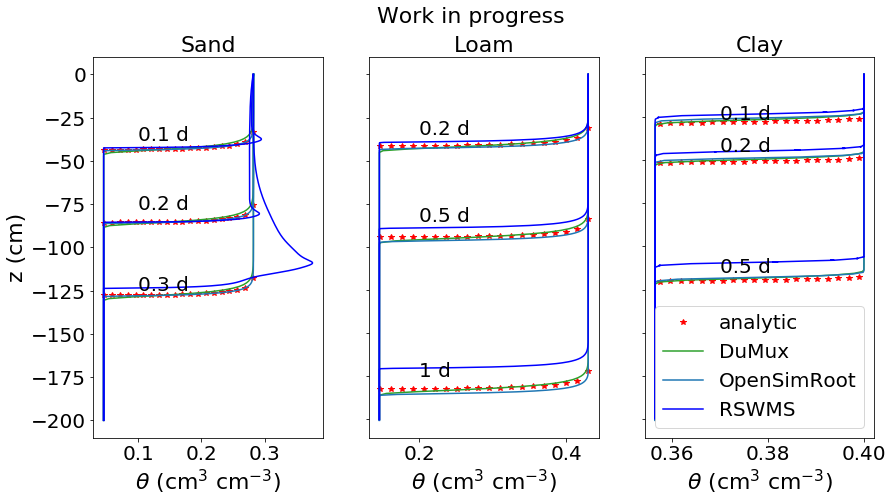

Name		 N	 R²		 R
DuMux	 20700 	 0.47402726 	 0.68849638
DuMux	 20700 	 0.75488331 	 0.86884021
DuMux	 20700 	 0.76815861 	 0.87644658
DuMux	 20700 	 0.46297506 	 0.68042271
DuMux	 20700 	 0.77426579 	 0.87992374
DuMux	 20700 	 0.37585380 	 0.61306917
DuMux	 20700 	 0.35639504 	 0.59698831
DuMux	 20700 	 0.56984142 	 0.75487842
DuMux	 20700 	 0.74315863 	 0.86206649
OpenSimRoot	 1001 	 0.49058679 	 0.70041901
OpenSimRoot	 1001 	 0.75333406 	 0.86794819
OpenSimRoot	 1001 	 0.75110252 	 0.86666171
OpenSimRoot	 402 	 0.48102524 	 0.69355983
OpenSimRoot	 402 	 0.77364537 	 0.87957113
OpenSimRoot	 402 	 0.31807808 	 0.56398411
OpenSimRoot	 202 	 0.34261273 	 0.58533130
OpenSimRoot	 202 	 0.56040673 	 0.74860319
OpenSimRoot	 202 	 0.74116823 	 0.86091128
RSWMS	 801 	 0.35818016 	 -0.59848155
RSWMS	 801 	 0.59186713 	 -0.76932901
RSWMS	 801 	 0.61289943 	 -0.78287894
RSWMS	 801 	 0.44815804 	 -0.66944607
RSWMS	 801 	 0.76175162 	 -0.87278383
RSWMS	 801 	 0.48127880 	 -0.69374261
RSWMS	 804 	 0

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))  
for j in range(0,3): # axis
    for k in range(0,3): 
        z = z3[3*j+k]
        theta = theta3[3*j+k]
        interp = interp1d(theta, z,  kind='linear', fill_value='extrapolate', bounds_error =False ) 
        theta_ = np.linspace(np.min(theta),np.max(theta),20)        
        pl, = ax[j].plot(theta_,interp(theta_),'r*') # Analytic solution
        if k==0:
            pl.set_label("analytic") 
        
r, rsme, rsquare, nn, l = [], [], [], [], []
cc = 0
#col = ['r','g','b','r','g','b']
col=["C2","C0","b"]
for dirname, dirnames, filenames in os.walk('M2.1 Numerical results/.'):    
    filenames.sort()
    for i,f in enumerate(filenames):            
        try:        
            data = []
            with open('M2.1 Numerical results/'+f) as fp: 
                for line in fp:
                    s = ast.literal_eval("["+line+"]")                
                    data.append(s)                      
            for j in range(0,3): # axis
                for k in range(0,3): 
                    l.append(f)                    
                    z = data[2*(3*j+k)]
                    theta = data[2*(3*j+k)+1]                     
                    pl, = ax[j].plot(theta,z,col[cc]) # numeric solution                     
                    interp = interp1d(theta3[3*j+k], z3[3*j+k],  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                    z_a = interp(sorted(theta)) # analytical solution at points                    
                    # Evaluate
                    oi, pi = z, z_a
                    om, pm = np.mean(oi), np.mean(pi)
                    nn.append(len(oi))
                    # calculate R
                    r_ =  np.sum((oi-om)*(pi-pm)) / (np.sqrt(np.sum(np.square(oi-om)))*np.sqrt(np.sum(np.square(pi-pm))) )
                    r.append(r_)
                    # calculate R^2
                    # r2 = np.sum(np.square(pi-om)) / np.sum(np.square(oi-om))                         
                    rsquare.append(r_*r_)            
                    # calculate RSME
                    rsme_ = np.square(np.sum(np.square(oi-pi)/nn[-1]))
                    rsme.append(rsme_)                                          
                    if k==0:
                        pl.set_label(f)                                      
                ax[j].set_xlabel("$\\theta$ (cm$^3$ cm$^{-3}$)")
                #ax[j].set_xticks(np.arange(0.0,0.4,0.1))
                if j==0: 
                    ax[j].set_ylabel("z (cm)") # all file data values are currently [m], I will change that soon                                                                                             
                else:
                    ax[j].set_yticklabels([])  
            cc+=1                                  
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)                  
ax[-1].legend() 
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
ax[0].text(0.1, -38, '0.1 d'); ax[0].text(0.1, -78, '0.2 d'); ax[0].text(0.1, -125, '0.3 d')
ax[1].text(0.2, -35, '0.2 d'); ax[1].text(0.2, -85, '0.5 d'); ax[1].text(0.2, -175, '1 d')
ax[2].text(0.37, -26, '0.1 d'); ax[2].text(0.37, -45, '0.2 d'); ax[2].text(0.37, -115, '0.5 d')
ax[0].set_title('Sand')
ax[1].set_title('Loam')
ax[2].set_title('Clay')
#plt.yticks(np.arange(-16,1,4))
#plt.savefig('m21_results.png', dpi=300, bbox_inches = "tight")
fig.suptitle("Work in progress")
plt.show()      

print("Name\t\t", "N\t", "R²\t\t", "R")
for i in range(0,len(nn)):
    print(l[i]+"\t",nn[i],"\t",'{:2.8f}'.format(rsquare[i]),"\t",'{:2.8f}'.format(r[i]) ) # '{:2.8f}'.format(rsme[i]),"\t",

## References
Vanderborght, J and Kasteel, R and Herbst, M and Javaux, M and Thiery, D and Vanclooster, M and Mouvet, C and Vereecken, H (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221